C:\Users\rvign\AppData\Local\Temp\ipykernel_9144\380013020.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sensor_force = data.sensordata[int(model.sensor('contact_force').adr):int(model.sensor('contact_force').adr)+3]


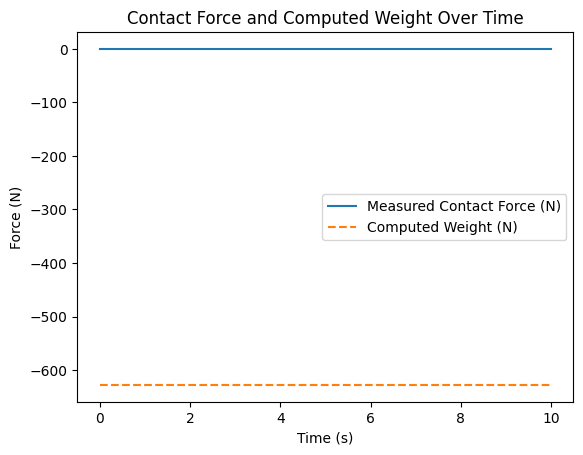

The measured contact force does not match the computed weight.


In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import mediapy as media

# MJCF model as a string
mjcf_model = """
<mujoco model="force_sensor_test">
    <compiler angle="degree" coordinate="local"/>
    <option timestep="0.01" gravity="0 0 -9.81"/>

    <!-- Define the world body -->
    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" pos="0 0 0" size="10 10 0.1" rgba="0.2 0.3 0.4 1"/>

        <!-- Cuboid -->
        <body name="cuboid" pos="0 0 1">
            <geom name="cuboid_geom" type="box" size="0.2 0.2 0.2" rgba="1 0 0 1"/>
            <joint name="cuboid_joint" type="free"/>
            <site name="contact_site" pos="0 0 -0.2" size="0.05" rgba="0 1 0 1"/>
        </body>
    </worldbody>

    <!-- Sensors -->
    <sensor>
        <!-- Force sensor at the cuboid's contact site -->
        <force site="contact_site" name="contact_force"/>
    </sensor>

    <!-- Actuators (optional, for later use) -->
    <actuator>
        <!-- Add actuators here if needed -->
    </actuator>
</mujoco>
"""

# Write the MJCF model to a temporary file
with tempfile.NamedTemporaryFile(suffix=".xml", delete=False) as tmp_file:
    tmp_file.write(mjcf_model.encode())
    tmp_filepath = tmp_file.name

# Load the model and create a simulation
model = mujoco.MjModel.from_xml_path(tmp_filepath)
data = mujoco.MjData(model)

# Create a renderer
renderer = mujoco.Renderer(model)

# Function to compute the weight of the cuboid
def compute_cuboid_weight():
    cuboid_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "cuboid")
    cuboid_mass = model.body_mass[cuboid_body_id]
    gravity = np.array([0, 0, -9.81])
    weight = cuboid_mass * gravity
    return weight

# Initialize arrays to store contact forces and weights
contact_forces = []
weights = []

# Initialize list to store frames
frames = []
cam=mujoco.MjvCamera()

options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
# Simulation parameters
sim_duration = 10  # duration in seconds
framerate = 30  # frames per second

# Step the simulation to let the cuboid settle on the ground
for _ in range(int(sim_duration / model.opt.timestep)):
    mujoco.mj_step(model, data)
    # Get the contact force measurement from the sensor
    sensor_force = data.sensordata[int(model.sensor('contact_force').adr):int(model.sensor('contact_force').adr)+3]
    contact_forces.append(sensor_force.copy())

    # Compute the weight of the cuboid
    cuboid_weight = compute_cuboid_weight()
    weights.append(cuboid_weight.copy())

    # Capture frames for the video
    if len(frames) < data.time * framerate:
        cam.lookat=data.subtree_com[0]
        renderer.update_scene(data,cam,options)
        pixels = renderer.render()
        frames.append(pixels)

# Convert to numpy arrays for plotting
contact_forces = np.array(contact_forces)
weights = np.array(weights)

# Plot the contact force and computed weight
time = np.arange(len(contact_forces)) * model.opt.timestep
plt.figure()
plt.plot(time, contact_forces[:, 2], label='Measured Contact Force (N)')
plt.plot(time, weights[:, 2], label='Computed Weight (N)', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.title('Contact Force and Computed Weight Over Time')
plt.show()


# Check if the measured contact force matches the computed weight
tolerance = 1e-2  # Tolerance for comparison
if np.allclose(sensor_force, cuboid_weight, atol=tolerance):
    print("The measured contact force matches the computed weight.")
else:
    print("The measured contact force does not match the computed weight.")

# Show the video using mediapy
media.show_video(frames, fps=framerate)


In [3]:
np.linalg.vector_norm(data.sensor('contact_force').data)

np.float64(4.998044758413132e-13)

C:\Users\rvign\AppData\Local\Temp\ipykernel_9144\1449302651.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sensor_force = data.sensordata[int(model.sensor('contact_force').adr):int(model.sensor('contact_force').adr)+3]


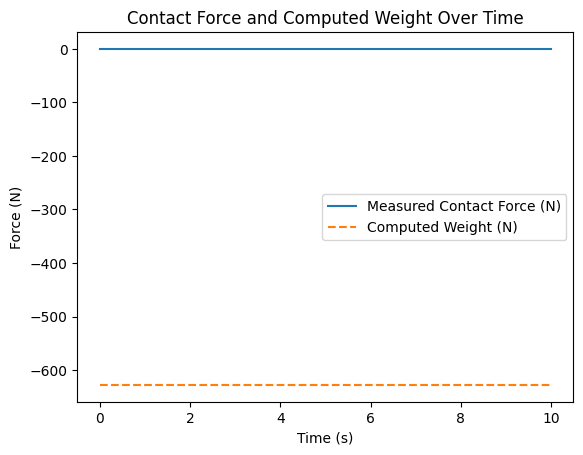

The measured contact force does not match the computed weight.


In [2]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import mediapy as media

# MJCF model as a string
mjcf_model = """
<mujoco model="force_sensor_test">
    <compiler angle="degree" coordinate="local"/>
    <option timestep="0.01" gravity="0 0 -9.81"/>

    <!-- Define the world body -->
    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" pos="0 0 0" size="10 10 0.1" rgba="0.2 0.3 0.4 1"/>

        <!-- Cuboid -->
        <body name="cuboid" pos="0 0 1">
            <geom name="cuboid_geom" type="box" size="0.2 0.2 0.2" rgba="1 0 0 1"/>
            <joint name="cuboid_joint" type="free"/>
            <!-- Sensor site similar to quadruped -->
            <site name="contact_site" pos="0 0 -0.2" size="0.05" rgba="0 1 0 1"/>
            <body name="dummy_body" pos="0 0 -0.25">
                <inertial pos="0 0 0" mass="0.000001" diaginertia="0 0 0"/>
                <geom type="box" size="0.01 0.01 0.01" rgba="0 1 0 1"/>
            </body>
        </body>
    </worldbody>

    <!-- Sensors -->
    <sensor>
        <!-- Force sensor at the cuboid's contact site -->
        <force site="contact_site" name="contact_force"/>
    </sensor>
</mujoco>
"""

# Write the MJCF model to a temporary file
with tempfile.NamedTemporaryFile(suffix=".xml", delete=False) as tmp_file:
    tmp_file.write(mjcf_model.encode())
    tmp_filepath = tmp_file.name

# Load the model and create a simulation
model = mujoco.MjModel.from_xml_path(tmp_filepath)
data = mujoco.MjData(model)

# Create a renderer
renderer = mujoco.Renderer(model)

# Function to compute the weight of the cuboid
def compute_cuboid_weight():
    cuboid_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "cuboid")
    cuboid_mass = model.body_mass[cuboid_body_id]
    gravity = np.array([0, 0, -9.81])
    weight = cuboid_mass * gravity
    return weight

# Initialize arrays to store contact forces and weights
contact_forces = []
weights = []

# Initialize list to store frames
frames = []

options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
# Simulation parameters
sim_duration = 10  # duration in seconds
framerate = 30  # frames per second

# Step the simulation to let the cuboid settle on the ground
for _ in range(int(sim_duration / model.opt.timestep)):
    mujoco.mj_step(model, data)
    # Get the contact force measurement from the sensor
    sensor_force = data.sensordata[int(model.sensor('contact_force').adr):int(model.sensor('contact_force').adr)+3]
    contact_forces.append(sensor_force.copy())

    # Compute the weight of the cuboid
    cuboid_weight = compute_cuboid_weight()
    weights.append(cuboid_weight.copy())

    # Capture frames for the video
    if len(frames) < data.time * framerate:
        renderer.update_scene(data,-1,)
        pixels = renderer.render()
        frames.append(pixels)

# Convert to numpy arrays for plotting
contact_forces = np.array(contact_forces)
weights = np.array(weights)

# Plot the contact force and computed weight
time = np.arange(len(contact_forces)) * model.opt.timestep
plt.figure()
plt.plot(time, contact_forces[:, 2], label='Measured Contact Force (N)')
plt.plot(time, weights[:, 2], label='Computed Weight (N)', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.title('Contact Force and Computed Weight Over Time')
plt.show()

# Check if the measured contact force matches the computed weight
tolerance = 1e-2  # Tolerance for comparison
if np.allclose(sensor_force, cuboid_weight, atol=tolerance):
    print("The measured contact force matches the computed weight.")
else:
    print("The measured contact force does not match the computed weight.")

# Show the video using mediapy
media.show_video(frames, fps=framerate)


[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]
[ 0.00000000e+00  0.00000000e+00 -1.77635684e-14]


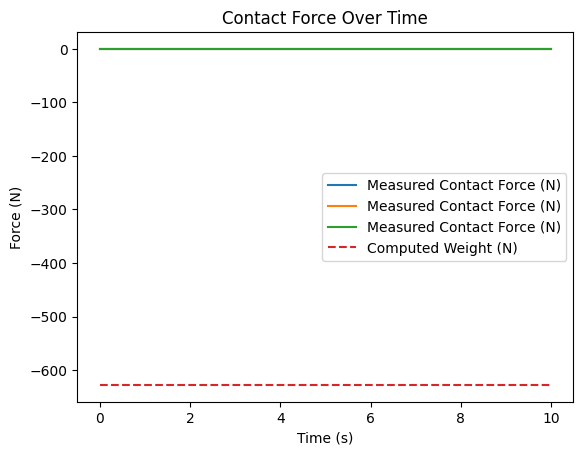

In [3]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import mediapy as media

# MJCF model as a string
mjcf_model = """
<mujoco model="touch_sensor_test">
    <compiler angle="degree" coordinate="local"/>
    <option timestep="0.01" gravity="0 0 -9.81"/>

    <!-- Define the world body -->
    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" pos="0 0 0" size="10 10 0.1" rgba="0.5 0.5 0.5 1"/>

        <!-- Cuboid -->
        <body name="cuboid" pos="0 0 10" >
            <geom name="cuboid_geom" type="box" size="0.2 0.2 0.2" rgba="1 0 0 1" mass="10"/>
            <joint name="cuboid_joint" type="free"/>
            <site name="contact_site" pos="0 0 -0.2" size="5" rgba="0 1 0 1"/>
        </body>

        <!-- Add a directional light -->
        <light name="light1" pos="0 0 2" dir="0 0 -1" diffuse="1.0 1.0 1.0" specular="0.5 0.5 0.5"/>
        <light name="light2" pos="2 2 2" dir="-1 -1 -1" diffuse="0.8 0.8 0.8" specular="0.3 0.3 0.3"/>
    </worldbody>

    <!-- Sensors -->
    <sensor>
        <!-- Touch sensor at the cuboid's contact site -->
        <force site="contact_site" name="contact_touch"/>
    </sensor>

    <!-- Actuators (optional, for later use) -->
    <actuator>
        <!-- Add actuators here if needed -->
    </actuator>
</mujoco>
"""
def compute_cuboid_weight():
    cuboid_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "cuboid")
    cuboid_mass = model.body_mass[cuboid_body_id]
    gravity = np.array([0, 0, -9.81])
    weight = cuboid_mass * gravity
    return weight

# Function to run MuJoCo simulation and capture contact forces
def run_simulation_and_capture_contact(model, sim_duration=10, framerate=30):
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)

    # Initialize arrays to store contact forces and weights
    contact_forces = []
    weights = []

    # Initialize list to store frames
    frames = []

    # Set up camera and options for rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

    cam = mujoco.MjvCamera()
    cam.azimuth = 90
    cam.elevation = -30
    cam.distance = 4.0
    cam.lookat = np.array([0, 0, 0])

    # Step the simulation to let the cuboid settle on the ground
    for _ in range(int(sim_duration / model.opt.timestep)):
        mujoco.mj_step(model, data)
        
        # Get the net contact force measurement from the touch sensor
        sensor_touch = data.sensordata
        print(sensor_touch)
        contact_forces.append(sensor_touch)
        

        # Capture frames for the video
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, cam, options)
            pixels = renderer.render()
            frames.append(pixels)

    # Convert to numpy arrays for plotting
    contact_forces = np.array(contact_forces)

    # Return captured data
    return contact_forces, frames

# Write the MJCF model to a temporary file
with tempfile.NamedTemporaryFile(suffix=".xml", delete=False) as tmp_file:
    tmp_file.write(mjcf_model.encode())
    tmp_filepath = tmp_file.name

# Load the model
model = mujoco.MjModel.from_xml_path(tmp_filepath)

# Run simulation and capture contact forces
contact_forces, frames = run_simulation_and_capture_contact(model)
weights = np.array(weights)

# Plot the contact force over time
time = np.arange(len(contact_forces)) * model.opt.timestep
plt.figure()
plt.plot(time, contact_forces, label='Measured Contact Force (N)')
plt.plot(time, weights[:, 2], label='Computed Weight (N)', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.title('Contact Force Over Time')
plt.show()

# Show the video using mediapy
media.show_video(frames, fps=30)


In [5]:
print(data.ncon)
print(data.sensordata[-1])

4
-4.547473508864641e-13


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[15007.86493506]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1020.61402757]
[59.02917071]
[99.28263276]
[97.99801075]
[98.05522632]
[98.06505164]
[98.07356932]
[98.0799799]
[98.0848341]
[98.08850992]
[98.09129402]
[98.09340306]
[98.095000

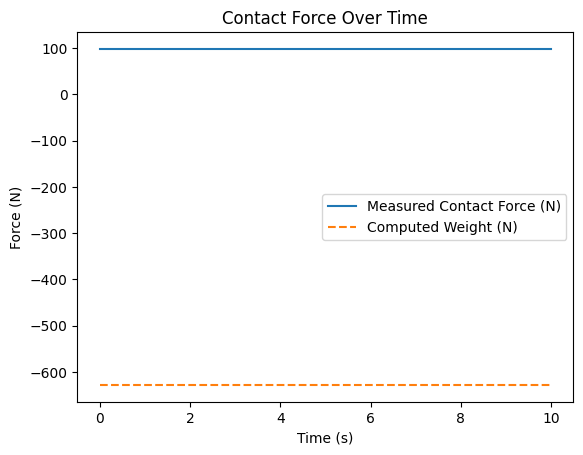

4
-4.547473508864641e-13


In [11]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import mediapy as media

# MJCF model as a string
mjcf_model = """
<mujoco model="touch_sensor_test">
    <compiler angle="degree" coordinate="local"/>
    <option timestep="0.01" gravity="0 0 -9.81"/>

    <!-- Define the world body -->
    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" pos="0 0 0" size="10 10 0.1" rgba="0.5 0.5 0.5 1"/>

        <!-- Cuboid -->
        <body name="cuboid" pos="0 0 10" >
            <geom name="cuboid_geom" type="box" size="0.2 0.2 0.2" rgba="1 0 0 1" mass="10"/>
            <joint name="cuboid_joint" type="free"/>
            <site name="contact_site" pos="0 0 -0.2" size="0.5" rgba="0 1 0 1"/>
        </body>

        <!-- Add a directional light -->
        <light name="light1" pos="0 0 2" dir="0 0 -1" diffuse="1.0 1.0 1.0" specular="0.5 0.5 0.5"/>
        <light name="light2" pos="2 2 2" dir="-1 -1 -1" diffuse="0.8 0.8 0.8" specular="0.3 0.3 0.3"/>
    </worldbody>

    <!-- Sensors -->
    <sensor>
        <!-- Touch sensor at the cuboid's contact site -->
        <touch site="contact_site" name="contact_touch"/>
    </sensor>

    <!-- Actuators (optional, for later use) -->
    <actuator>
        <!-- Add actuators here if needed -->
    </actuator>
</mujoco>
"""
def compute_cuboid_weight():
    cuboid_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "cuboid")
    cuboid_mass = model.body_mass[cuboid_body_id]
    gravity = np.array([0, 0, -9.81])
    weight = cuboid_mass * gravity
    return weight

# Function to run MuJoCo simulation and capture contact forces
def run_simulation_and_capture_contact(model, sim_duration=10, framerate=30):
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)

    # Initialize arrays to store contact forces and weights
    contact_forces = []
    weights = []

    # Initialize list to store frames
    frames = []

    # Set up camera and options for rendering
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)
    options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

    cam = mujoco.MjvCamera()
    cam.azimuth = 90
    cam.elevation = -30
    cam.distance = 4.0
    cam.lookat = np.array([0, 0, 0])

    # Step the simulation to let the cuboid settle on the ground
    for _ in range(int(sim_duration / model.opt.timestep)):
        mujoco.mj_step(model, data)
        #mujoco.mj_collision(model, data)
        # Get the net contact force measurement from the touch sensor
        sensor_touch = data.sensordata
        print(sensor_touch)
        contact_forces.append(sensor_touch)
        

        # Capture frames for the video
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, cam, options)
            pixels = renderer.render()
            frames.append(pixels)

    # Convert to numpy arrays for plotting
    contact_forces = np.array(contact_forces)

    # Return captured data
    return contact_forces, frames

# Write the MJCF model to a temporary file
with tempfile.NamedTemporaryFile(suffix=".xml", delete=False) as tmp_file:
    tmp_file.write(mjcf_model.encode())
    tmp_filepath = tmp_file.name

# Load the model
model = mujoco.MjModel.from_xml_path(tmp_filepath)

# Run simulation and capture contact forces
contact_forces, frames = run_simulation_and_capture_contact(model)
weights = np.array(weights)

# Plot the contact force over time
time = np.arange(len(contact_forces)) * model.opt.timestep
plt.figure()
plt.plot(time, contact_forces, label='Measured Contact Force (N)')
plt.plot(time, weights[:, 2], label='Computed Weight (N)', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.title('Contact Force Over Time')
plt.show()

# Show the video using mediapy
media.show_video(frames, fps=30)
print(data.ncon)
print(data.sensordata[-1])
